In [6]:
import random
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import csv


In [7]:
# Set up the Selenium WebDriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')  # Run in headless mode to avoid opening a browser window
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3')

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

In [8]:
# Function to add random delay
def random_sleep():
    sleep_time = random.uniform(2, 5)  # Random delay between 2 and 5 seconds
    print(f"Sleeping for {round(sleep_time, 2)} seconds...")
    time.sleep(sleep_time)

In [9]:
# Function to scrape reviews from a page
def scrape_reviews(soup):
    # Find all review sections
    reviews = soup.find_all('section', {'class': lambda x: x and 'reviewContent' in x})
    # Extract relevant information from each review
    for review in reviews:
        try:
            # Extract the rating
            rating = review.find('div', {'data-service-review-rating': True})['data-service-review-rating']
        except AttributeError:
            rating = 'No rating'
        
        try:
            # Extract the title and review text
            review_title = review.find('h2', {'class': lambda x: x and 'heading' in x}).text.strip()
            review_text = review.find('p', {'class': lambda x: x and 'typography' in x}).text.strip()
        except AttributeError:
            review_title = 'No title'
            review_text = 'No text'
        
        try:
            # Extract and clean up the date
            review_date = review.find('p', {'class': lambda x: x and 'typography_body-m' in x}).text.strip()
            review_date = review_date.replace('Date of experience:', '').strip()
        except AttributeError:
            review_date = 'No date'

        # Print extracted information
        print(f"Rating: {rating}")
        print(f"Title: {review_title}")
        print(f"Review: {review_text}")
        print(f"Date: {review_date}")
        print("-" * 50)

        # Append extracted information to the list
        all_reviews.append({
            'Rating': rating,
            'Title': review_title,
            'Review': review_text,
            'Date': review_date
        })

In [10]:
#URL of the Old Navy Trustpilot reviews page
base_url = "https://www.trustpilot.com/review/oldnavy.ca"
all_reviews = []

# Load the initial page
driver.get(base_url)
random_sleep()  # Add random sleep before starting

# Keep scraping while there's a next page
while True:
    # Parse the current page with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Scrape reviews from the current page
    scrape_reviews(soup)

    try:
        # Find the "Next page" button using the class or name
        next_page_element = driver.find_element('xpath', "//a[@name='pagination-button-next']")

        # Get the href of the next page
        next_page_url = next_page_element.get_attribute('href')

        # If the URL is relative, construct the full URL
        if next_page_url.startswith('/'):
            next_page_url = "https://www.trustpilot.com" + next_page_url

        # Navigate to the next page
        print(f"Navigating to {next_page_url}")
        driver.get(next_page_url)
        random_sleep()  # Random sleep before loading the next page
    except Exception as e:
        print("No more pages to scrape. Exiting.")
        break  # Exit the loop when no next page is found

# Close the browser
driver.quit()

Sleeping for 4.3 seconds...
Rating: 1
Title: Terrible delivery experience
Review: Terrible delivery experience. Originally sent two out of three items, late, saying they couldn't verify my address. Spent 30 mins on the phone with "customer service" which felt akin to smashing my head against concrete. Was falsely promised expedited delivery. Three weeks later and another 20 minute call to "service" I was given two excuses (multiple choice?) That the package was damaged and they didn't have my address (agent two blamed agent one for typing it in incorrectly)No sincere apologies, no effort to make the moment right, no direct answers (nice script tho) and utterly shoddy effort. Very frustrating.
Date: September 13, 2024
--------------------------------------------------
Rating: 1
Title: Old Navy uses OnTrac/Lasership for…
Review: Old Navy uses OnTrac/Lasership for deliver. This company is a scam. They are a bunch of liars who constantly say they attempted delivery or need more information

In [11]:
# Save the scraped reviews to a CSV file
with open('oldnavy_reviews.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=['Rating', 'Title', 'Review', 'Date'])
    writer.writeheader()
    writer.writerows(all_reviews)

print(f"Scraped {len(all_reviews)} reviews and saved to 'oldnavy_reviews.csv'.")

Scraped 422 reviews and saved to 'oldnavy_reviews.csv'.


In [12]:
import pandas as pd
import time
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

# Load the CSV file
csv_path = 'oldnavy_reviews.csv'
df = pd.read_csv(csv_path)

# Define your Azure Text Analytics credentials
endpoint = ""
key = ""

# Authenticate the client
def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
        endpoint=endpoint, 
        credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

# Function to analyze sentiment with rate limiting and retry mechanism
def sentiment_analysis_with_rate_limit(client, documents, batch_size=10, sleep_time=1):
    all_sentiments = []
    num_docs = len(documents)

    for i in range(0, num_docs, batch_size):
        batch = documents[i:i + batch_size]
        try:
            response = client.analyze_sentiment(documents=batch)
            for doc in response:
                if not doc.is_error:
                    all_sentiments.append({
                        'document': doc.id,
                        'sentiment': doc.sentiment,
                        'positive': doc.confidence_scores.positive,
                        'neutral': doc.confidence_scores.neutral,
                        'negative': doc.confidence_scores.negative
                    })
                else:
                    all_sentiments.append({
                        'document': doc.id,
                        'error': doc.error.message
                    })
        except HttpResponseError as e:
            if e.status_code == 429:  # Too many requests error
                print("Rate limit hit, waiting to retry...")
                time.sleep(sleep_time)  # Retry after sleep time
                response = client.analyze_sentiment(documents=batch)  # Retry
            else:
                print(f"Error occurred: {e}")
                break

        time.sleep(sleep_time)  # Sleep between each batch to avoid hitting rate limit

    return pd.DataFrame(all_sentiments)

# Assuming the CSV has a column 'Review'
reviews = df['Review'].tolist()
documents = [{"id": str(i), "language": "en", "text": review} for i, review in enumerate(reviews)]

# Perform sentiment analysis with rate limiting and batching
sentiment_df = sentiment_analysis_with_rate_limit(client, documents)

# Merge the results back with original data
df['Sentiment'] = sentiment_df['sentiment']

# Save the new dataframe to CSV
df.to_csv('oldnavy_reviews_with_sentiment.csv', index=False)

In [13]:
df.head()

,Rating,Title,Review,Date,Sentiment
0,1,Terrible delivery experience,Terrible delivery experience. Originally sent ...,"September 13, 2024",negative
1,1,Old Navy uses OnTrac/Lasership for…,Old Navy uses OnTrac/Lasership for deliver. Th...,"August 02, 2024",negative
2,5,Affordable clothes,Great clothes and customer service. I DONT kno...,"August 20, 2024",mixed
3,1,STOP USING LASERSHIP/ONTRAC,Old Navy’s products are fine for the price. Th...,"August 02, 2024",mixed
4,1,If 1 could give 0 stars I would,If 1 could give 0 stars I would. per old navy ...,"August 19, 2024",mixed


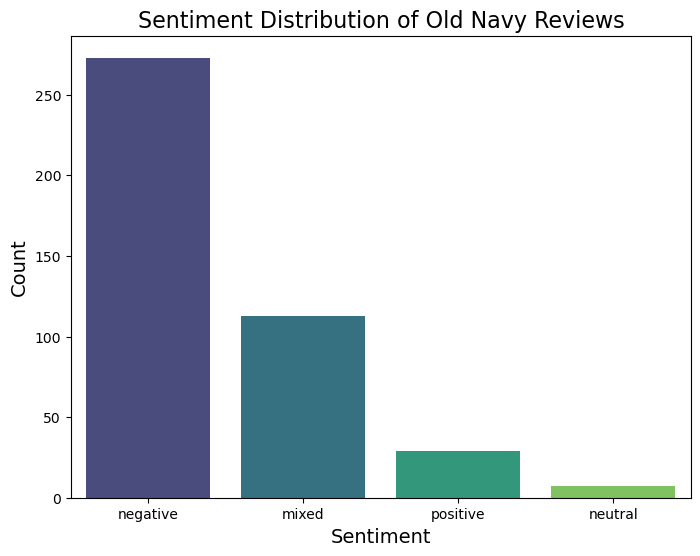

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of each sentiment type
sentiment_counts = df['Sentiment'].value_counts()

# Set up the figure size and plot
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

# Add labels and title
plt.title('Sentiment Distribution of Old Navy Reviews', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Show the plot
plt.show()

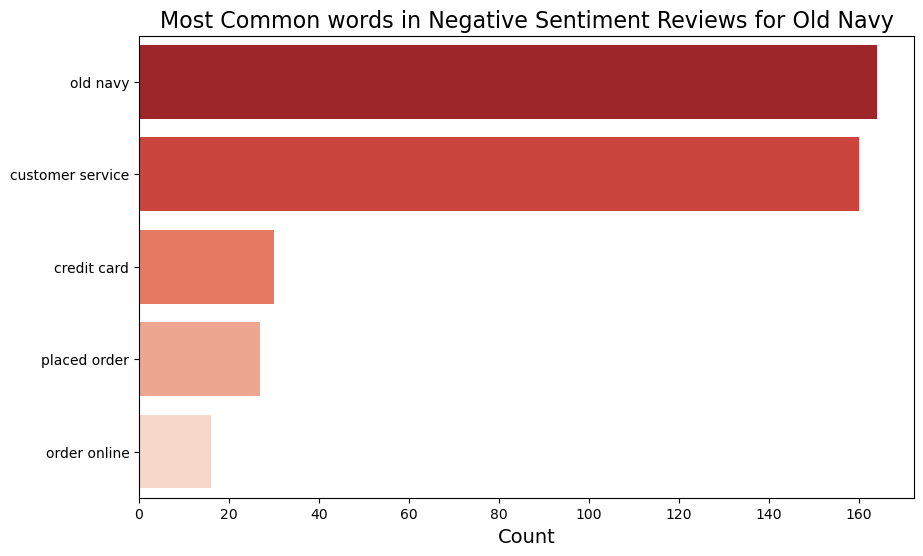

In [15]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

negative_reviews = df[df['Sentiment'] == 'negative']['Review']

# Function to clean and tokenize text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()  # Tokenize text
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]  # Remove stopwords
    return tokens

# Create a list of all tokens from negative reviews
all_tokens = []
for review in negative_reviews:
    all_tokens.extend(clean_text(review))

# Create bigrams (2-word phrases)
bigrams = zip(all_tokens, all_tokens[1:])
bigram_phrases = [' '.join(bigram) for bigram in bigrams]

# Count the most common bigrams
bigram_counter = Counter(bigram_phrases)
common_bigrams = bigram_counter.most_common(5)  # Get top 10 most common bigrams

# Convert the results to a dataframe for visualization
common_bigrams_df = pd.DataFrame(common_bigrams, columns=['Bigram', 'Count'])

# Plot the most common bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Bigram', data=common_bigrams_df, palette='Reds_r')

# Add labels and title
plt.title('Most Common words in Negative Sentiment Reviews for Old Navy', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('', fontsize=14)

# Show the plot
plt.show()